In [1]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-balance/build/python')

import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt, Bool

mi.set_variant('cuda_ad_rgb')

In [2]:
scene = mi.load_file("/home/jonathan/Documents/mi3-balance/resources/data/scenes/matpreview/matpreview.xml")

In [3]:
from emitter_sampling import RadianceCacheEM

radiance_cache_exact = RadianceCacheEM(scene, 256, 128)

Fitting spherical harmonics to scene...


100%|██████████| 3/3 [00:30<00:00, 10.06s/it]

Fitting complete.


In [4]:
from vertex_bsdf import Principled

bsdf_train = Principled(specular = 0.5, has_metallic = False)

for mesh in scene.shapes():
    if not(mesh.is_mesh()):
        continue
    bsdf_train.initialize_mesh_attributes(mesh, [0.5, 0.5, 0.5], m_roughness = 0.9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04896696..1.6709813].


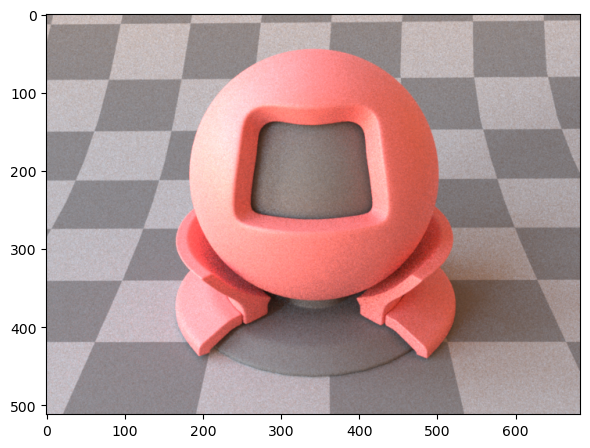

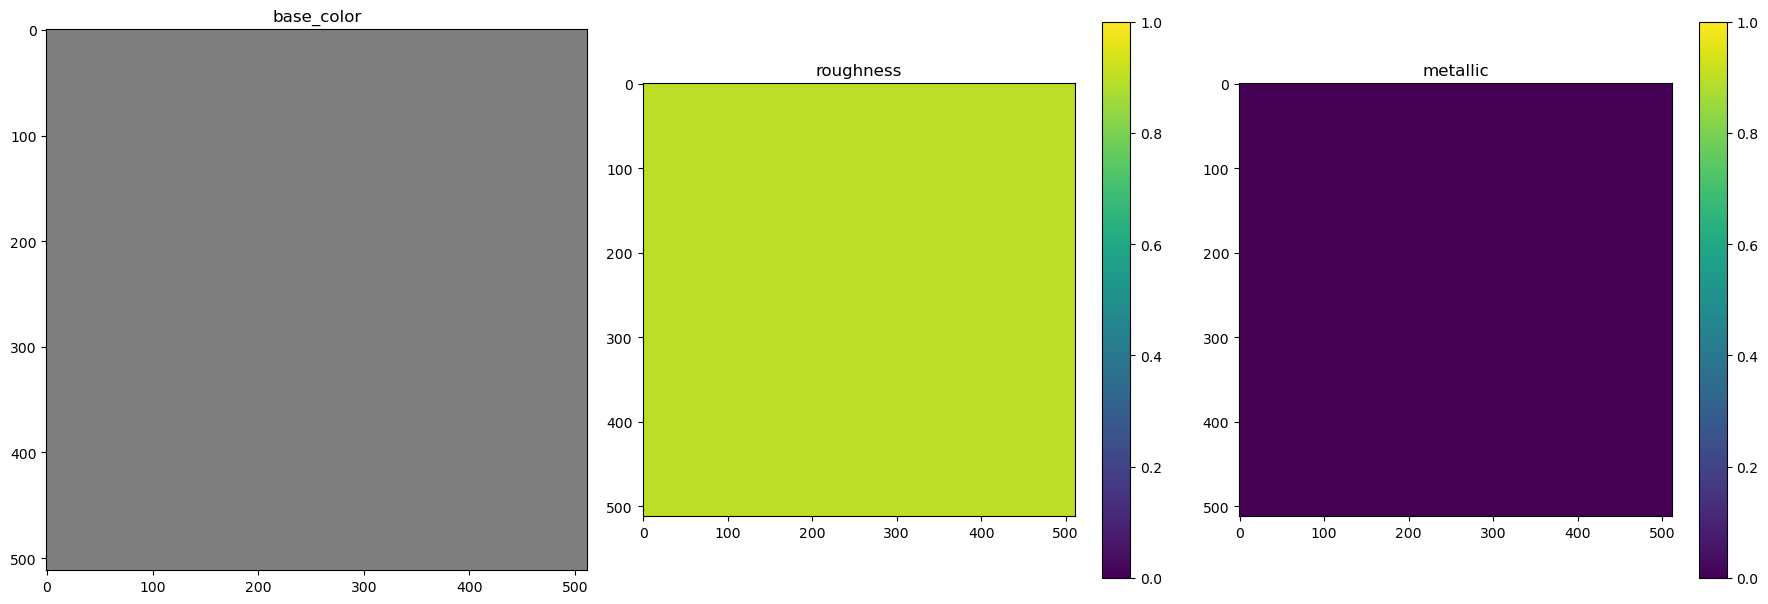

In [5]:
from bsdf_utils import ps_visualize_textures, render_attributes, render_attributes_gt
import matplotlib.pyplot as plt
import numpy as np

# ps_visualize_textures(scene)
out = render_attributes(scene, (512, 512), False)

# Scene render
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(mi.render(scene) ** (1.0 / 2.2)); plt.tight_layout()

# BSDF initial values
plt.figure(figsize=(18,6), dpi=100)
plt.subplot(131); plt.imshow(out[:,:,:3]); plt.title("base_color")
plt.subplot(132); plt.imshow(out[:,:,3], vmin=0.0, vmax=1.0); plt.title("roughness"); plt.colorbar()
plt.subplot(133); plt.imshow(out[:,:,4], vmin=0.0, vmax=1.0); plt.title("metallic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out[:,:,5], vmin=0.0, vmax=1.0); plt.title("anisotropic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out[:,:,6], vmin=0.0, vmax=1.0); plt.title("spec_tint");  plt.colorbar()
plt.tight_layout()


In [6]:
NUM_GEO_SAMPLES = 1 << 10 # 10
NUM_WI_DIRECTIONS = 256 << 0

%load_ext autoreload
%autoreload 2

In [7]:
from emitter_sampling import compute_loss
from radiosity_sh import SceneSurfaceSampler
from regularizer import TVRegularizer
from time import time

params = mi.traverse(scene)
keys = [key for key in params.keys() if "vertex_bsdf" in key]
opt = mi.ad.Adam(lr=0.05)
for key in keys:
    dr.enable_grad(params[key])
    opt[key] = params[key]
    params.update(opt)

scene_sampler = SceneSurfaceSampler(scene, method='mesh-res')
regularizer = TVRegularizer(scene)

losses = []
for it in range(150):
    if it % 50 == 0:
        render_attributes(scene, (512, 512), True, f"output/itr={it}")

    time1 = time()

    # Evaluate the objective function for the current BSDF params
    loss = compute_loss(scene_sampler, radiance_cache_exact, bsdf_train, 
        NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, num_wo = 16, rng_state = it)
    
    with dr.resume_grad():
        loss += 1e-1 * regularizer.compute_loss(scene, ['vertex_bsdf_roughness'])
    
    # with dr.resume_grad():
    #     loss += 3e-4 * regularizer.compute_loss(scene, ['vertex_bsdf_roughness'])

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    for key in keys:
        opt[key] = dr.clip(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    losses.append(loss.numpy())
    time2 = time()
    print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}")

Iteration 001 [2.217797]: Loss = [0.106016]
Iteration 002 [0.339524]: Loss = [0.109035]
Iteration 003 [0.332653]: Loss = [0.103039]
Iteration 004 [0.329617]: Loss = [0.0964616]
Iteration 005 [0.332363]: Loss = [0.0834828]
Iteration 006 [0.331424]: Loss = [0.0800351]
Iteration 007 [0.329542]: Loss = [0.0647725]
Iteration 008 [0.337565]: Loss = [0.0550011]
Iteration 009 [0.331542]: Loss = [0.0457431]
Iteration 010 [0.329813]: Loss = [0.0478391]
Iteration 011 [0.339687]: Loss = [0.0378628]
Iteration 012 [0.333637]: Loss = [0.0328666]
Iteration 013 [0.332279]: Loss = [0.0279879]
Iteration 014 [0.338582]: Loss = [0.0237747]
Iteration 015 [0.329771]: Loss = [0.0234705]
Iteration 016 [0.333052]: Loss = [0.0187355]
Iteration 017 [0.334823]: Loss = [0.0244119]
Iteration 018 [0.338221]: Loss = [0.0175063]
Iteration 019 [0.339459]: Loss = [0.0235652]
Iteration 020 [0.334080]: Loss = [0.0137431]
Iteration 021 [0.339271]: Loss = [0.0135438]
Iteration 022 [0.334327]: Loss = [0.0157457]
Iteration 023

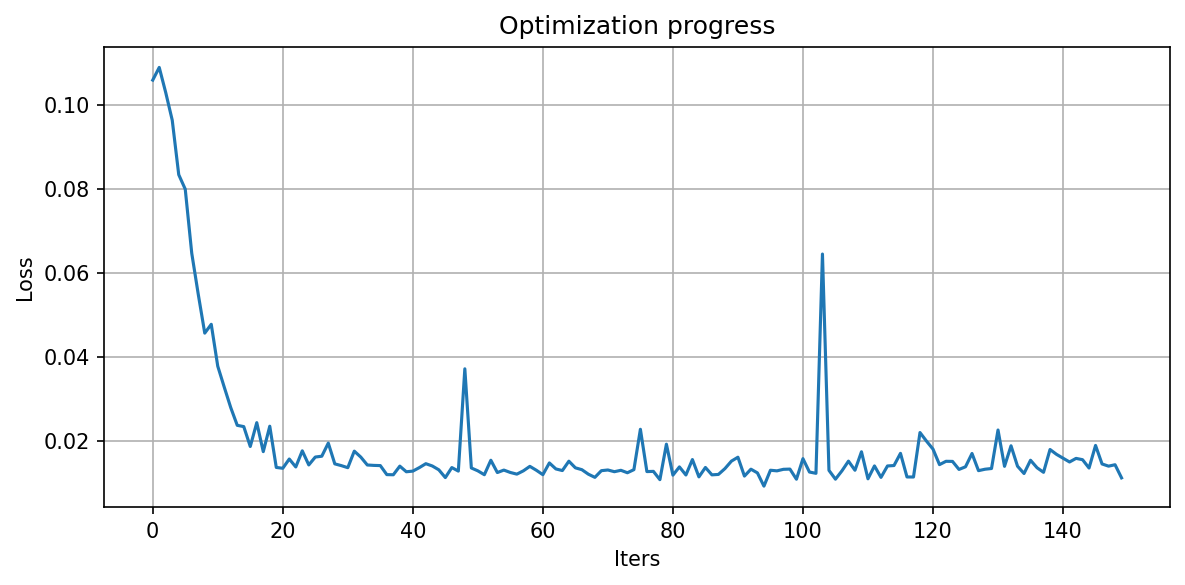

In [8]:
plt.figure(figsize=(8,4), dpi=150)
plt.title("Optimization progress")
plt.plot(np.array(losses))
plt.xlabel("Iters")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout()
plt.savefig("./output/loss.png")

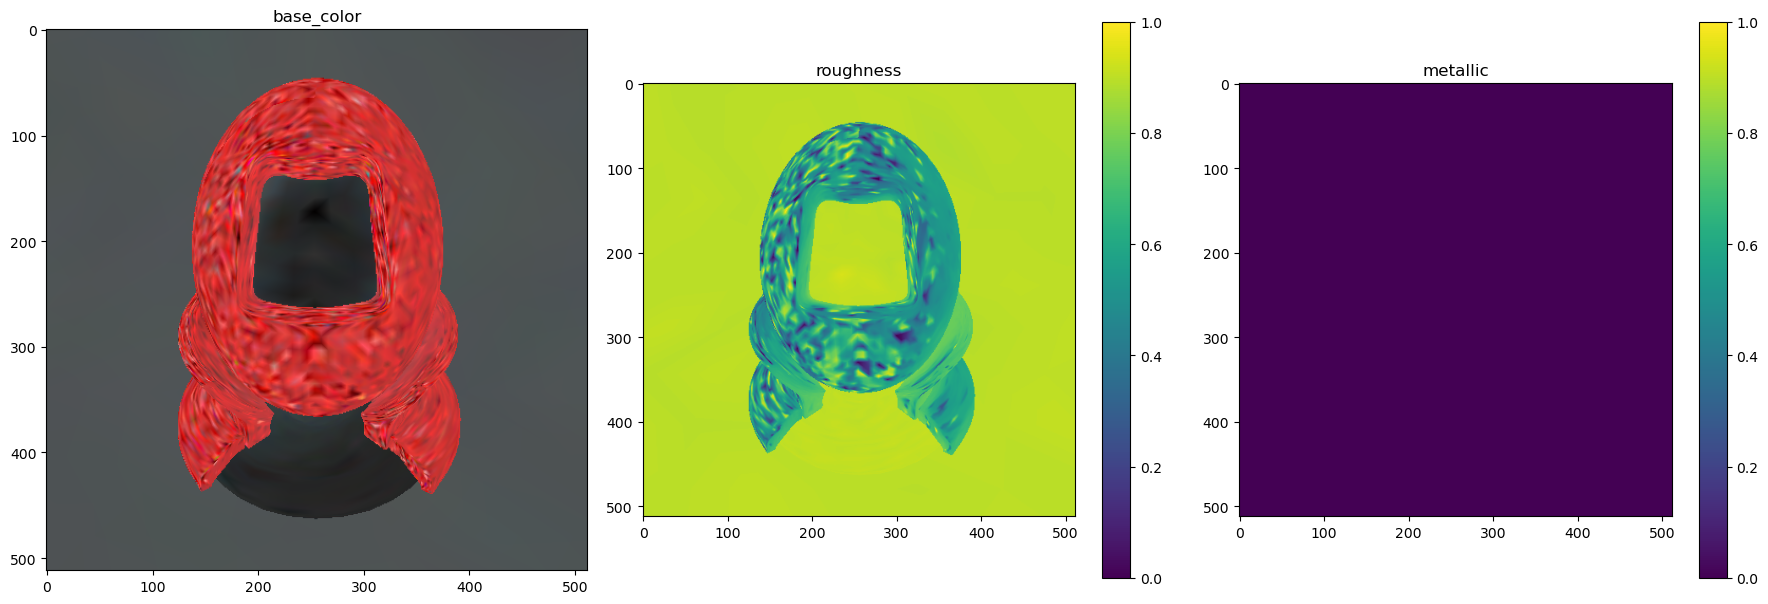

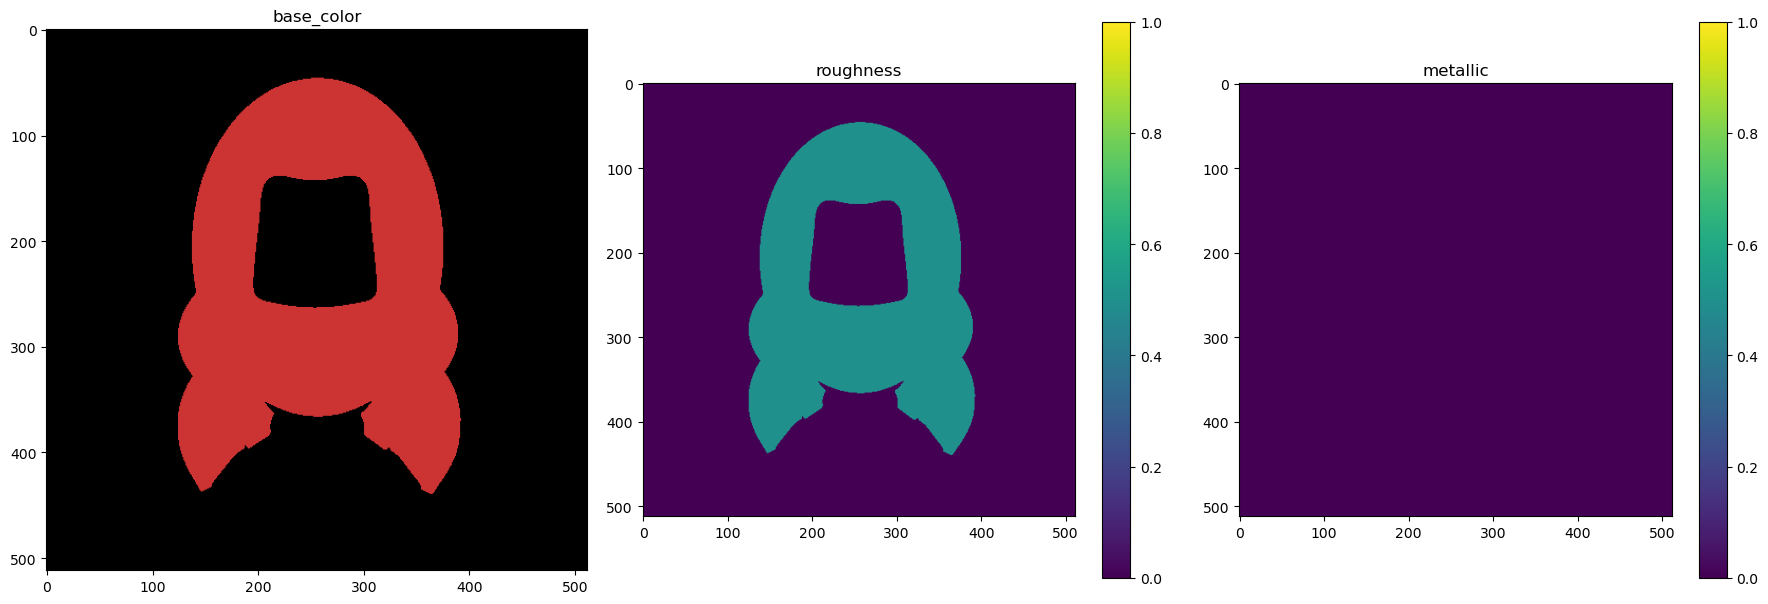

In [9]:
out = render_attributes(scene, (512,512), True, "output/final")

# BSDF final values
plt.figure(figsize=(18,6), dpi=100)
plt.subplot(131); plt.imshow(out[:,:,:3]); plt.title("base_color")
plt.subplot(132); plt.imshow(out[:,:,3], vmin=0.0, vmax=1.0); plt.title("roughness"); plt.colorbar()
plt.subplot(133); plt.imshow(out[:,:,4], vmin=0.0, vmax=1.0); plt.title("metallic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out[:,:,5], vmin=0.0, vmax=1.0); plt.title("anisotropic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out[:,:,6], vmin=0.0, vmax=1.0); plt.title("spec_tint");  plt.colorbar()
plt.tight_layout()
plt.savefig("output/final.png")

out_gt = render_attributes_gt(scene, (512,512), True, "output/reference")

# BSDF final values
plt.figure(figsize=(18,6), dpi=100)
plt.subplot(131); plt.imshow(out_gt[:,:,:3]); plt.title("base_color")
plt.subplot(132); plt.imshow(out_gt[:,:,3], vmin=0.0, vmax=1.0); plt.title("roughness"); plt.colorbar()
plt.subplot(133); plt.imshow(out_gt[:,:,4], vmin=0.0, vmax=1.0); plt.title("metallic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out_gt[:,:,5], vmin=0.0, vmax=1.0); plt.title("anisotropic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out_gt[:,:,6], vmin=0.0, vmax=1.0); plt.title("spec_tint");  plt.colorbar()
plt.tight_layout()
plt.savefig("output/reference.png")

In [10]:
ps_visualize_textures(scene)

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 550.120
